In [43]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
import warnings
warnings.filterwarnings('ignore')

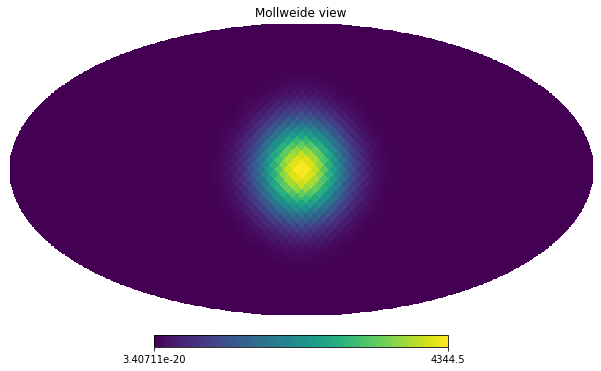

In [77]:
# Set the number of sources and the coordinates for the input
nres = 1000 # number of theta/phi bins (so nres**2 total)
nside = 16
npix = hp.nside2npix(nside)

theta = np.hstack(np.repeat(np.linspace(0, np.pi, nres), nres).reshape(nres, nres))
phi = np.hstack(np.repeat(np.linspace(-np.pi, np.pi, nres), nres).reshape(nres, nres).T)
beamthetastd = 0.075
beamphistd = 0.1
beammu = np.array([np.pi/2, 0])
covar = np.matrix([[beamthetastd, 0], [0, beamphistd]])
invcovar_thetatheta = np.linalg.inv(covar)[0, 0]
invcovar_phiphi = np.linalg.inv(covar)[1, 1]
beam = np.zeros(nres**2)
# for i in range(nres**2):
#     beam[i] = 1/(2*np.pi*beamthetastd*beamphistd) * np.exp(-0.5*((np.array([theta[i], phi[i]]-beammu).T)@np.linalg.inv(covar)@np.array([theta[i], phi[i]]-beammu)))
beam = 1/(2*np.pi*beamthetastd*beamphistd) * np.exp(-0.5*(invcovar_thetatheta*(theta-beammu[0])**2 + invcovar_phiphi*(phi-beammu[1])**2))
# Go from HEALPix coordinates to indices
indices = hp.ang2pix(nside, theta, phi)

# Initate the map and fill it with the values
hpxmap = np.zeros(npix, dtype=np.float)
for i in range(nres**2):
    hpxmap[indices[i]] += beam[i]

# Inspect the map
rotator = hp.Rotator(rot=[0, 0, 0], eulertype='ZYX')
hpxmap = rotator.rotate_map_pixel(hpxmap)
hp.mollview(hpxmap)
# hp.fitsfunc.write_map('gaussian_beam.fits', hpxmap)
# hp.fitsfunc.write_map('gaussian_beam_norm.fits', hpxmap/np.max(hpxmap))

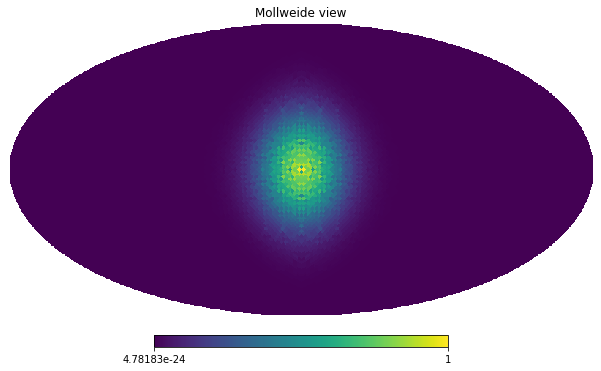

In [71]:
#returns a healpix map pixel array of a gaussian beam with 0 off-diagonal covariance pointing at (theta, phi)
def point_beam(theta, phi, beamthetastd=0.1, beamphistd=0.1, nres=400, nside=32, invert=True):
    inv = -1 if invert else 1
    thetas = np.hstack(np.repeat(np.linspace(0, np.pi, nres), nres).reshape(nres, nres))
    phis = np.hstack(np.repeat(np.linspace(-np.pi, np.pi, nres), nres).reshape(nres, nres).T)
    np.where(phis)
    thetadist = thetas-theta
    phidist = np.minimum(np.minimum(np.abs(phis-inv*phi), np.abs(phis+2*np.pi-inv*phi)), \
                         np.abs(phis-2*np.pi-inv*phi)) #periodic boundary condition
    beam = 1/(2*np.pi*np.sqrt(beamthetastd*beamphistd)) * np.exp(-0.5*(thetadist**2/beamthetastd + \
                                                              phidist**2/beamphistd))
    indices = hp.ang2pix(nside, thetas, phis, nest=False)
    hpxmap = np.zeros(hp.nside2npix(nside), dtype=np.float)
    for i in range(nres**2):
        hpxmap[indices[i]] += beam[i]
    return hpxmap/np.max(hpxmap)
hpxmap = point_beam(np.pi/2, 0)
hp.mollview(hpxmap)

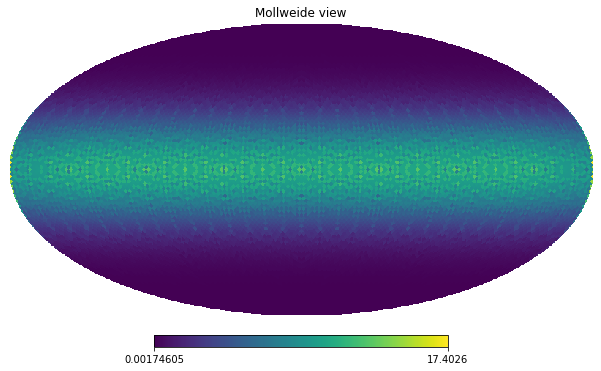

In [64]:
#ignore healpy rotations for now. We'll create the sky coverage matrix analytically for each pointing direction
def sky_coverage(lons, lats, coordsys='galactic', nres=400, nside=32, progress=0):
    skycov = np.zeros((lons.shape[0], hp.nside2npix(nside)))
    if coordsys in ['celestial', 'equatorial', 'c', 'C']: #conversion to galactic coords
        for i in range(lons.shape[0]):
            c = SkyCoord(lons[i], lats[i], frame='icrs', unit='deg')
            lons[i] = c.galactic.l.degree
            lats[i] = c.galactic.b.degree

    for i in range(lons.shape[0]):
        phi = (lons[i]%360-180)*np.pi/180
        theta = (90-lats[i])*np.pi/180
        beammap = point_beam(theta, phi, nres=nres, nside=nside)
        skycov[i] = beammap
        if progress != 0 and i%progress==0:
            print(i)
    return skycov

nsteps = 100
ls = np.linspace(0, 360, nsteps)
bs = np.linspace(0, 0, nsteps)
skycov = sky_coverage(ls, bs)
hp.mollview(np.sum(skycov, axis=0))

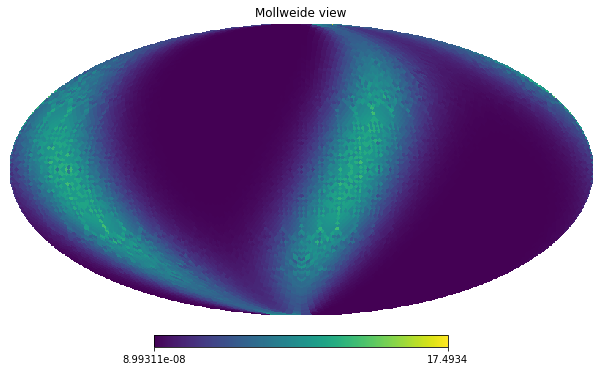

In [46]:
#say we want to give the path of the beam in equatorial coordinates:
ras = np.linspace(0, 360, nsteps)
decs = np.linspace(0, 0, nsteps)
skycov = sky_coverage(ras, decs, coordsys='c')
hp.mollview(np.sum(skycov, axis=0))

In [56]:
def compute_B(skycov, lmax=15):
    alms = np.full((skycov.shape[0], int((lmax+2)*(lmax+1)/2.0)), 0.+0.j)
    for beamnumber in range(nsteps):
        alms[beamnumber] = hp.map2alm(skycov[beamnumber], lmax=lmax)
    return alms

def compute_corr(B, l=1, m=0, lmax=15):
    reals10, imags10 = get_alm(B, l, m, lmax)
    realcorrs = np.zeros(int((lmax+2)*(lmax+1)/2.0))
    imagcorrs = np.zeros(int((lmax+2)*(lmax+1)/2.0))
    for l in range(lmax):
        for m in range(l+1):
            realslm, imagslm = get_alm(B, l, m, lmax)
            realcorrs[hp.Alm.getidx(15, l, m)] = np.correlate(reals10, realslm)
            imagcorrs[hp.Alm.getidx(15, l, m)] = np.correlate(imags10, imagslm)
    return realcorrs, imagcorrs

def get_alm(B, l, m, lmax):
    idx = hp.Alm.getidx(lmax, l, m)
    real = np.real(B[:, idx])
    imag = np.imag(B[:, idx])
    return real, imag

0
100
200
300
400
500
600
700
800
900


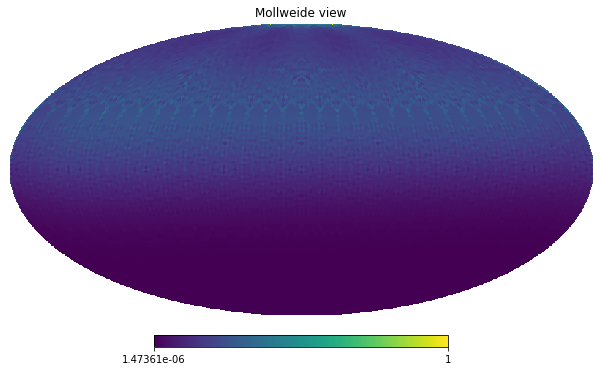

In [67]:
nsteps = 1000
ls = np.linspace(0, 3600, nsteps) % 360
bs = np.linspace(0, 90, nsteps)
skycov = sky_coverage(ls, bs, nsteps=nsteps, progress=100)
hp.mollview(np.sum(skycov, axis=0)/np.max(np.sum(skycov, axis=0)))

ValueError: The Axes must have been created in the present figure

<Figure size 432x288 with 0 Axes>

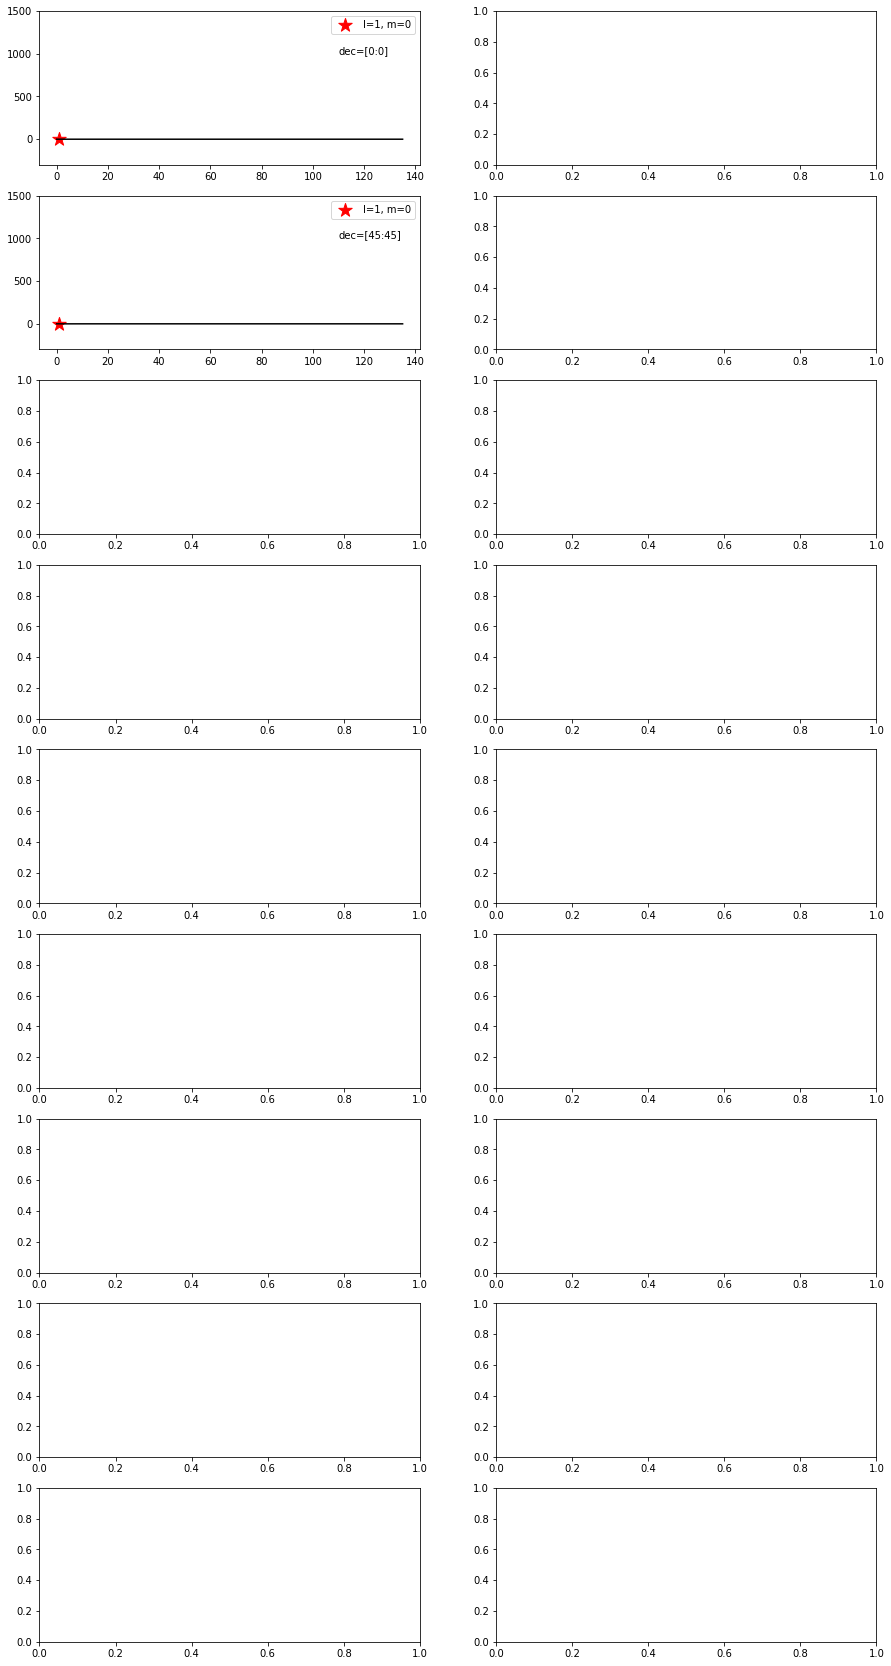

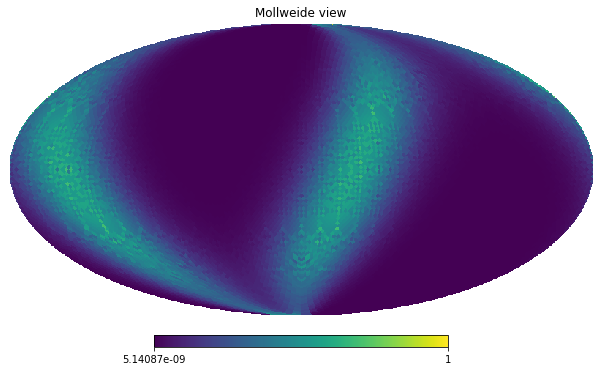

In [59]:
plt.clf()
fig, ax = plt.subplots(9, 2, figsize=(10, 20))
trial_orbits = [[0, 0], [45, 45], [-45, -45], [80, 80], [-80, -80],
               [0, 45], [0, 90], [-45, 45], [-90, 90]]
nsteps = 100
for i in range(len(trial_orbits)):
    trial_orbit = trial_orbits[i]
    ras = np.linspace(0, 360, nsteps)
    decs = np.linspace(trial_orbit[0], trial_orbit[1], nsteps)
    skycov = sky_coverage(ras, decs, coordsys='c')
    B = compute_B(skycov)
    realcorrs, imagcorrs = compute_corr(B)
    ax[i][0].plot(realcorrs, color='black')
    ax[i][0].scatter(1, realcorrs[1], color='red', marker='*', s=200, label='l=1, m=0')
    ax[i][0].legend()
    
    plt.axes(ax[i][1]) #visualize the telescope beam path
    hp.mollview(np.sum(skycov, axis=0)/np.max(np.sum(skycov, axis=0)))
# fig.savefig('out.pdf')